# JAX-CFD demo

This initial demonstration shows how to use JAX-CFD to simulate decaying turbulence in 2D.

In [1]:
import jax
import jax.numpy as jnp
import jax_cfd.base as cfd
import numpy as np
import seaborn
import xarray


In [2]:
size = 256
density = 1.
viscosity = 1e-3
seed = 0
inner_steps = 25
outer_steps = 200

max_velocity = 1.0
cfl_safety_factor = 0.5

# Define the physical dimensions of the simulation.
grid = cfd.grids.Grid((size, size), domain=((0,  2*np.pi), (0, 2*np.pi)))

# Construct a random initial velocity. The `filtered_velocity_field` function
# ensures that the initial velocity is divergence free and it filters out
# high frequency fluctuations.
v_true = cfd.validation_problems.TaylorGreen((size, size), 
                                         viscosity=viscosity, kx=1, ky=1)
v0 = v_true.velocity(t=0)

# Choose a time step.
dt = cfd.equations.stable_time_step(
    max_velocity, cfl_safety_factor, viscosity, grid)

# Define a step function and use it to compute a trajectory.
step_fn = cfd.funcutils.repeated(
    cfd.equations.semi_implicit_navier_stokes(
        density=density, viscosity=viscosity, dt=dt, grid=grid),
    steps=inner_steps)
rollout_fn = jax.jit(cfd.funcutils.trajectory(step_fn, outer_steps))
%time _, trajectory = jax.device_get(rollout_fn(v0))

I0000 00:00:1715996239.191790  170535 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


CPU times: user 818 ms, sys: 131 ms, total: 949 ms
Wall time: 901 ms


In [3]:
# load into xarray for visualization and analysis
coords = {
    "x": np.linspace(0, 2 * np.pi, size, endpoint=False)
    + 2 * np.pi / 512,  # cell centered
    "y": np.linspace(0, 2 * np.pi, size, endpoint=False) + 2 * np.pi / 512,
    "time": dt * inner_steps * np.arange(outer_steps),
}

ds = xarray.Dataset(
    {
        "u": (("time", "x", "y"), trajectory[0].data),
        "v": (("time", "x", "y"), trajectory[1].data),
    },
    coords=coords,
)

vx_true = []
vy_true = []
for t in ds["time"]:
    vx, vy = v_true.velocity(t.data)
    vx_true.append(vx.data)
    vy_true.append(vy.data)

vx_true = np.stack(vx_true)
vy_true = np.stack(vy_true)

ds_true = xarray.Dataset(
    {
        "u": (("time", "x", "y"), vx_true),
        "v": (("time", "x", "y"), vy_true),
    },
    coords=coords,
)

In [4]:
def magnitude(ds):
    return jnp.sqrt(ds.u.data**2 + ds.v.data**2)


for _ds in [ds, ds_true]:
    _ds["velocity_magnitude"] = (("time", "x", "y"), magnitude(_ds))

error = np.sqrt((ds["u"] - vx_true) ** 2 + (ds["v"] - vy_true) ** 2)
error /= np.sqrt(vx_true ** 2 + vy_true ** 2)
print(f"Relative L2 error: {error.mean()/size:.5e}" )


Relative L2 error: 2.57672e-04


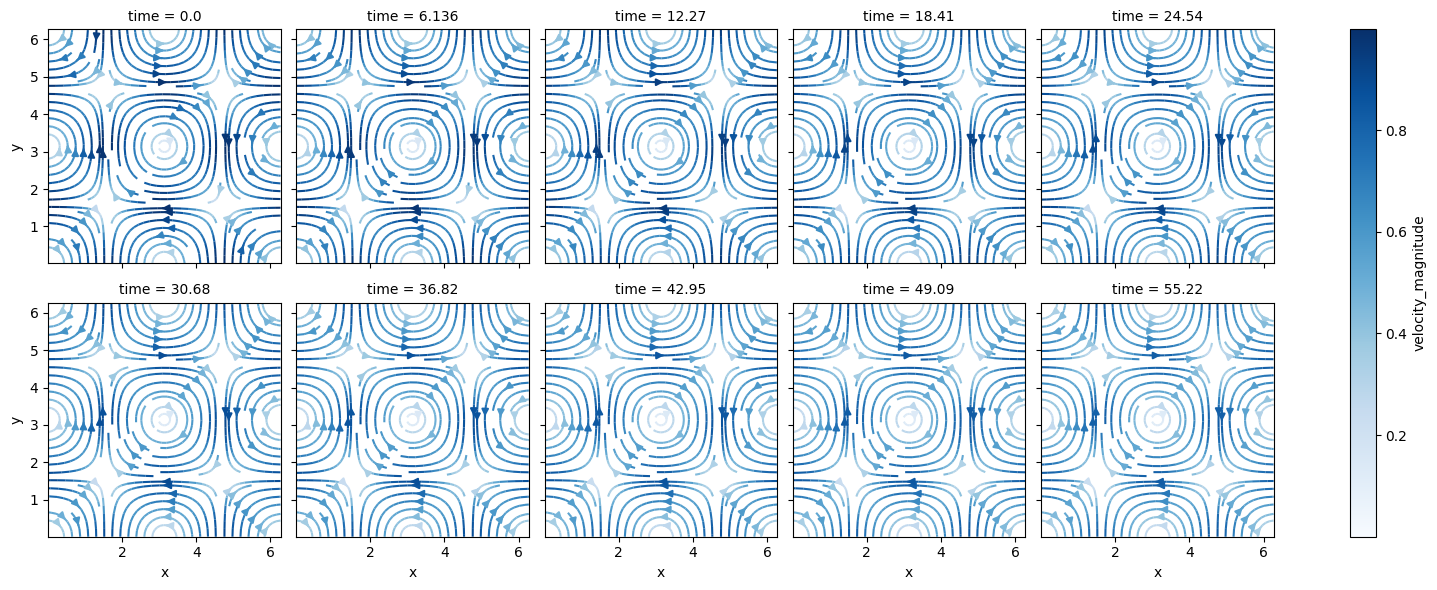

In [5]:
ds.thin(time=20).plot.streamplot(
        x="x",
        y="y",
        u="u",
        v="v",
        hue="velocity_magnitude",
        col="time",
        col_wrap=5,
        cmap=seaborn.color_palette("Blues", as_cmap=True),
    );

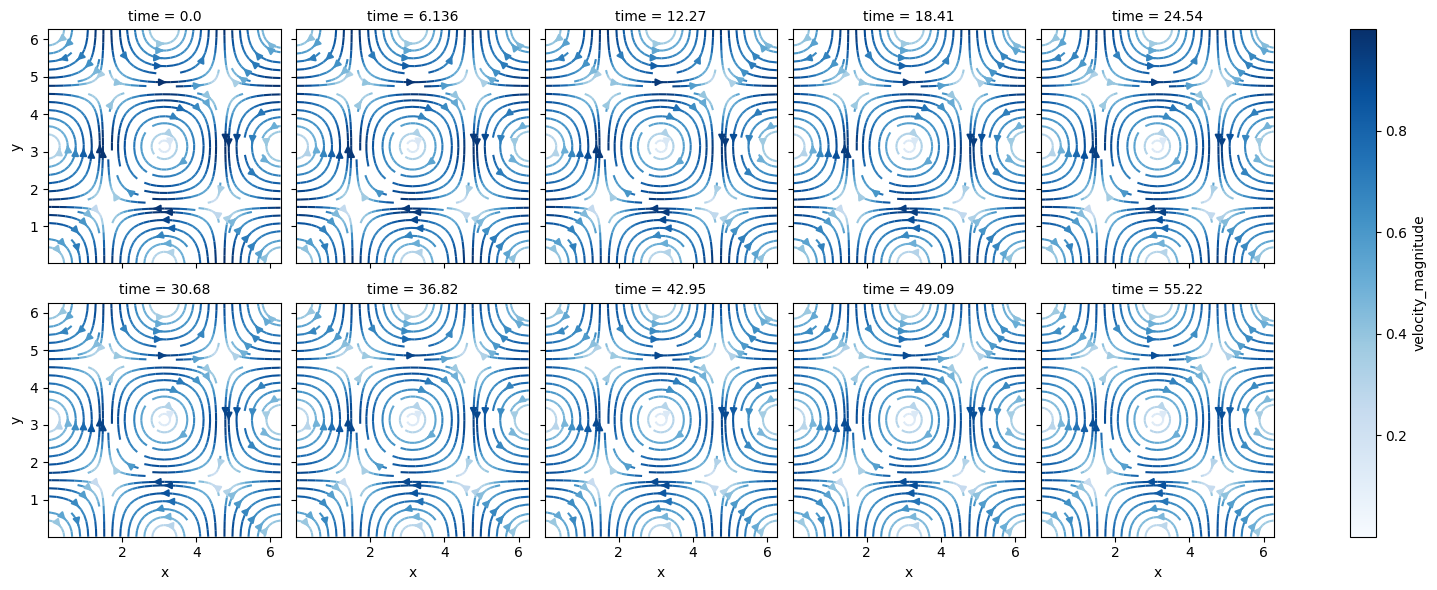

In [6]:
ds_true.thin(time=20).plot.streamplot(
        x="x",
        y="y",
        u="u",
        v="v",
        hue="velocity_magnitude",
        col="time",
        col_wrap=5,
        cmap=seaborn.color_palette("Blues", as_cmap=True),
    );